In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import iqr, norm
import statsmodels.stats.api as sms
import arch 

import statsmodels.tsa.seasonal as tsa
import statsmodels.graphics.tsaplots as tsap 
from statsmodels.tsa.stattools import adfuller

import warnings
warnings.filterwarnings("ignore")
np.random.seed(432)

In [46]:
inf1 = pd.read_csv('data/inflation.csv', delimiter=';')
inf1.index = pd.to_datetime(inf1.date, format='%d/%m/%Y')
inf1 = inf1.drop("date", axis = 1)
inf1['v_cpi'] = inf1['CPI'].pct_change(12)*100
inf1['vol_cpi1'] = inf1['CPI'].rolling(12).std()
# inf1.head()

In [47]:
simdf = inf1.loc['1993-01-01':'2021-12-01']
predf = simdf.loc['1992-01-01':'2004-12-01']
itdf  = simdf.loc['2005-01-01':'2021-12-01']

<AxesSubplot:xlabel='date'>

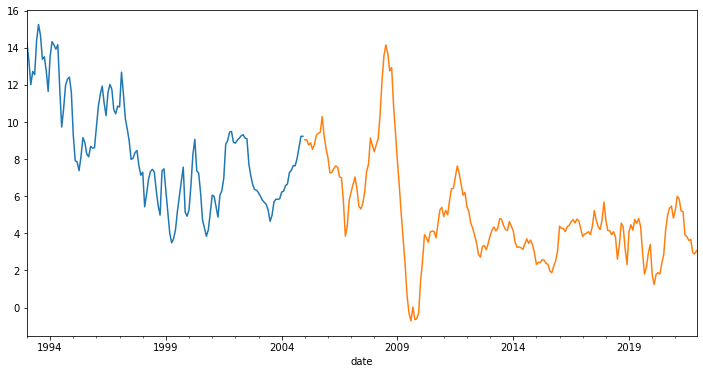

In [48]:
predf['v_cpi'].plot(figsize=(12,6))
itdf['v_cpi'].plot(figsize=(12,6))

In [49]:
# ADF Test for Stationarity on inflation

# Whole period
adf = adfuller(simdf['v_cpi'])[1] 
print(f"p value:{adf}", ", whole period: Series is Stationary" if adf <0.05 else ", Series is Non-Stationary")
# pre IT period
adf = adfuller(predf['v_cpi'])[1] 
print(f"p value:{adf}", ", Pre IT period: Series is Stationary" if adf <0.05 else ", Series is Non-Stationary")
# # it period
adf = adfuller(itdf['v_cpi'])[1] 
print(f"p value:{adf}", ", IT period: Series is Stationary" if adf <0.05 else ", Series is Non-Stationary")

p value:0.03841611734408168 , whole period: Series is Stationary
p value:0.15320315266553963 , Series is Non-Stationary
p value:0.19635563540377454 , Series is Non-Stationary


Aditive Decomposition for Inflation

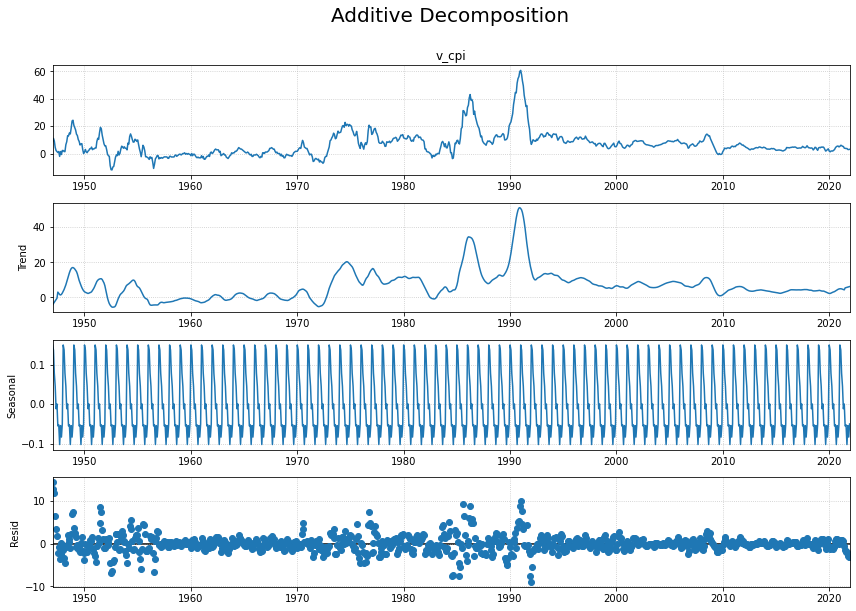

In [26]:
# # Additive Decomposition
plt.rcParams['figure.figsize'] = (12, 8);
a = tsa.seasonal_decompose(inf1['v_cpi'][12:],model='additive', extrapolate_trend='freq').plot()
plt.suptitle('Additive Decomposition', x = 0.525, y = 1.055, fontsize=20)
for i in range(len(a.axes)):
    a.axes[i].grid(axis='x', alpha=0.75, linestyle=':')
    a.axes[i].grid(axis='y', alpha=0.75, linestyle=':')
plt.show()

In [31]:
decomp = tsa.seasonal_decompose(inf1['v_cpi'][12:],model='additive', extrapolate_trend='freq')
df_rec = pd.concat([decomp.seasonal, decomp.trend, decomp.resid, decomp.observed], axis=1)
df_rec.columns = ['seas', 'trend', 'resid', 'actual_values']
df_rec.head()

,seas,trend,resid,actual_values
date,,,,
1947-01-01,0.149721,-4.176101,12.687797,8.661417
1947-02-01,0.136805,-3.423370,14.310186,11.023622
1947-03-01,0.078374,-2.670638,11.752570,9.160305
1947-04-01,0.045319,-1.917907,6.350199,4.477612
1947-05-01,-0.011785,-1.165175,3.366741,2.189781


In [52]:
inf1['inf_seasAdj'] = df_rec.resid

# IT regime dummy variable
inf1['IT_reg'] = np.zeros(len(inf1))
inf1['IT_reg']['2005-01-01':] = 1 

# lag creation
inf1["inf_seasAdj_l1"] = inf1['inf_seasAdj'].shift()
inf1["inf_seasAdj_l3"] = inf1['inf_seasAdj'].shift(3)
inf1["inf_seasAdj_l6"] = inf1['inf_seasAdj'].shift(6)
inf1["inf_seasAdj_l12"] = inf1['inf_seasAdj'].shift(12)
# drop na's
inf1.dropna(inplace=True)

# Working DataFrames
# complete "simetric" dataframe
simdf = inf1.loc['1993-01-01':'2021-12-01']
# Pre IT DataFrame
predf = simdf.loc['1993-01-01':'2004-12-01']
# IT DataFrame
itdf  = simdf.loc['2005-01-01':'2021-12-01']


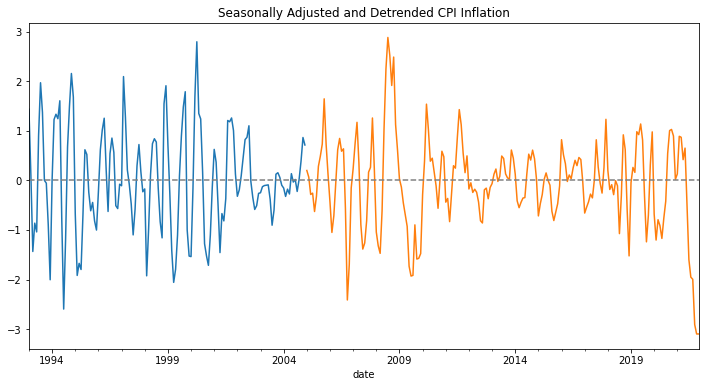

In [56]:
predf['inf_seasAdj'].plot(figsize=(12,6))
itdf['inf_seasAdj'].plot(figsize=(12,6))
plt.title('Seasonally Adjusted and Detrended CPI Inflation')
plt.axhline(y=0, color='grey', linestyle='--')

In [57]:
# ADF Test for Stationarity on Seasonally adjusted inflation
# Whole period
adf = adfuller(simdf['inf_seasAdj'])[1] 
print(f"p value:{adf}", ", whole period: Series is Stationary" if adf <0.05 else ", Series is Non-Stationary")
# pre IT period
adf = adfuller(predf['inf_seasAdj'])[1] 
print(f"p value:{adf}", ", Pre IT period: Series is Stationary" if adf <0.05 else ", Series is Non-Stationary")
# # it period
adf = adfuller(itdf['inf_seasAdj'])[1] 
print(f"p value:{adf}", ", IT period: Series is Stationary" if adf <0.05 else ", Series is Non-Stationary")

p value:1.870370093513673e-09 , whole period: Series is Stationary
p value:5.359212083582485e-05 , Pre IT period: Series is Stationary
p value:0.003422291791936745 , IT period: Series is Stationary


Modeling

Benchmark model

as in Kontonikas (2004)

$\pi = \gamma_0 + \gamma_1\pi_{t-1} + \gamma_2\pi_{t-3} + \gamma_3\pi_{t-6} + \gamma_4\pi_{t-12} + u_{1t}$

In [100]:
# Whole Period
mod1_1 = smf.ols(formula='inf_seasAdj ~ inf_seasAdj_l1 + inf_seasAdj_l3 + inf_seasAdj_l6 + inf_seasAdj_l12', data=simdf).fit() #+ inf_seasAdj_l3 + inf_seasAdj_l6
print(mod1_1.params)
print('Estimated persistence, Complete period: ',mod1_1.params.sum())

Intercept         -0.030400
inf_seasAdj_l1     0.706229
inf_seasAdj_l3    -0.258603
inf_seasAdj_l6     0.113868
inf_seasAdj_l12   -0.182637
dtype: float64
Estimated persistence, Complete period:  0.34845633047388025


In [108]:
mod1_1.pvalues
# All lags significant

Intercept          3.343030e-01
inf_seasAdj_l1     2.992466e-49
inf_seasAdj_l3     3.100467e-12
inf_seasAdj_l6     2.514321e-03
inf_seasAdj_l12    1.013216e-07
dtype: float64

In [101]:
# Pre IT Period
mod1_2 = smf.ols(formula='inf_seasAdj ~ inf_seasAdj_l1 + inf_seasAdj_l3 + inf_seasAdj_l6+ inf_seasAdj_l12', data=predf).fit()
print(mod1_2.params)
print('Estimated persistence, pre IT period: ', mod1_2.params.sum())


Intercept         -0.018508
inf_seasAdj_l1     0.601015
inf_seasAdj_l3    -0.326144
inf_seasAdj_l6     0.185841
inf_seasAdj_l12   -0.158810
dtype: float64
Estimated persistence, pre IT period:  0.28339313572024427


In [109]:
mod1_2.pvalues
# All lags significant

Intercept          7.202812e-01
inf_seasAdj_l1     1.660549e-16
inf_seasAdj_l3     6.798430e-08
inf_seasAdj_l6     3.750610e-03
inf_seasAdj_l12    3.598549e-04
dtype: float64

In [102]:
# IT Period
mod1_3 = smf.ols(formula='inf_seasAdj ~ inf_seasAdj_l1 + inf_seasAdj_l3 + inf_seasAdj_l6+ inf_seasAdj_l12', data=itdf).fit()
print(mod1_3.params)
print('Estimated persistence, IT period: ', mod1_3.params.sum())

Intercept         -0.029452
inf_seasAdj_l1     0.737347
inf_seasAdj_l3    -0.167511
inf_seasAdj_l6    -0.076055
inf_seasAdj_l12   -0.304669
dtype: float64
Estimated persistence, IT period:  0.15966046360458352


In [110]:
mod1_3.pvalues
# All lags significant

Intercept          4.082293e-01
inf_seasAdj_l1     2.102972e-32
inf_seasAdj_l3     5.356033e-04
inf_seasAdj_l6     1.092042e-01
inf_seasAdj_l12    1.357632e-08
dtype: float64

Persistence have decreased, with the introduction of the IT (lags significant in all models)

Model with whole period and Dummy for IT regime

as in Kontonikas (2004)

$\pi = \gamma_0 + (\gamma_1 + \gamma_5D_t)\pi_{t-1} + \gamma_2\pi_{t-3} + \gamma_3\pi_{t-6} + (\gamma_4 + \gamma_6D_t)\pi_{t-12} + u_{1t}$


In [116]:
# Whole Period
mod2_1 = smf.ols(formula='inf_seasAdj ~ inf_seasAdj_l1 + inf_seasAdj_l1*target + inf_seasAdj_l12 + inf_seasAdj_l12*target', data=simdf).fit()
mod2_1.params

Intercept                -0.019269
inf_seasAdj_l1            0.952551
target                   -0.002557
inf_seasAdj_l1:target    -0.064079
inf_seasAdj_l12          -0.505887
inf_seasAdj_l12:target    0.039983
dtype: float64

In [82]:
mod2_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            inf_seasAdj   R-squared:                       0.571
Model:                            OLS   Adj. R-squared:                  0.565
Method:                 Least Squares   F-statistic:                     91.14
Date:                Thu, 30 Jun 2022   Prob (F-statistic):           9.42e-61
Time:                        11:35:23   Log-Likelihood:                -329.71
No. Observations:                 348   AIC:                             671.4
Df Residuals:                     342   BIC:                             694.5
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -0.0193      0.125     -0.154      0.878      -0.266       0.227
inf_seasAdj_l1             0.9526      0.166      5.740      0.000       0.626       1.279
target                    -0.0026      0.022     -0.115      0.908      -0.046       0.041
inf_seasAdj_l1:target     -0.0641      0.028     -2.313      0.021      -0.119      -0.010
inf_seasAdj_l12           -0.5059      0.161     -3.148      0.002      -0.822      -0.190
inf_seasAdj_l12:target     0.0400      0.025      1.594      0.112      -0.009       0.089
==============================================================================
Omnibus:                        9.064   Durbin-Watson:                   1.156
Prob(Omnibus):                  0.011   Jarque-Bera (JB):               15.707
Skew:                           0.068   Prob(JB):                     0.000388
Kurtosis:                       4.032   Cond. No.                         45.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [83]:
mod2_1.params[3] + mod2_1.params[5]

# The sum is negative, means that IT has diminished the inflation 
# The interaction term with the 1st lag is negative and significant, means that IT has decreased the inflation persistance


-0.024096061067231

Chow Test

Perfomr Chow Test to check structural break in 2005 due to the IT introduction

In [120]:
# mod2_1 = sms.OLS(formula='inf_seasAdj ~ inf_seasAdj_l1 + inf_seasAdj_l1*target + inf_seasAdj_l12 + inf_seasAdj_l12*target', data=simdf).fit()
# mod2_1.params

In [121]:
# Recursive OLS residuals
# from statsmodels.stats.diagnostic import recursive_olsresiduals
# recres = recursive_olsresiduals(mod2_1, alpha=0.90)